In [285]:
import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from data_loader import CifarAlbumentationsDataset,\
    CIFAR_CLASS_LABELS, TRAIN_TRANSFORM, TEST_TRANSFORM
from utils import plot_misclassified_images
from explainer import grad_cam
from metrics import get_metrics
import model
from torch_lr_finder import LRFinder

import os

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel, update_bn
from torchmetrics.functional import accuracy

from main import LitResnet

In [281]:
epochs=20
batch_size=512
n_misclassif=20
n_grad_cam=20

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.37E-01


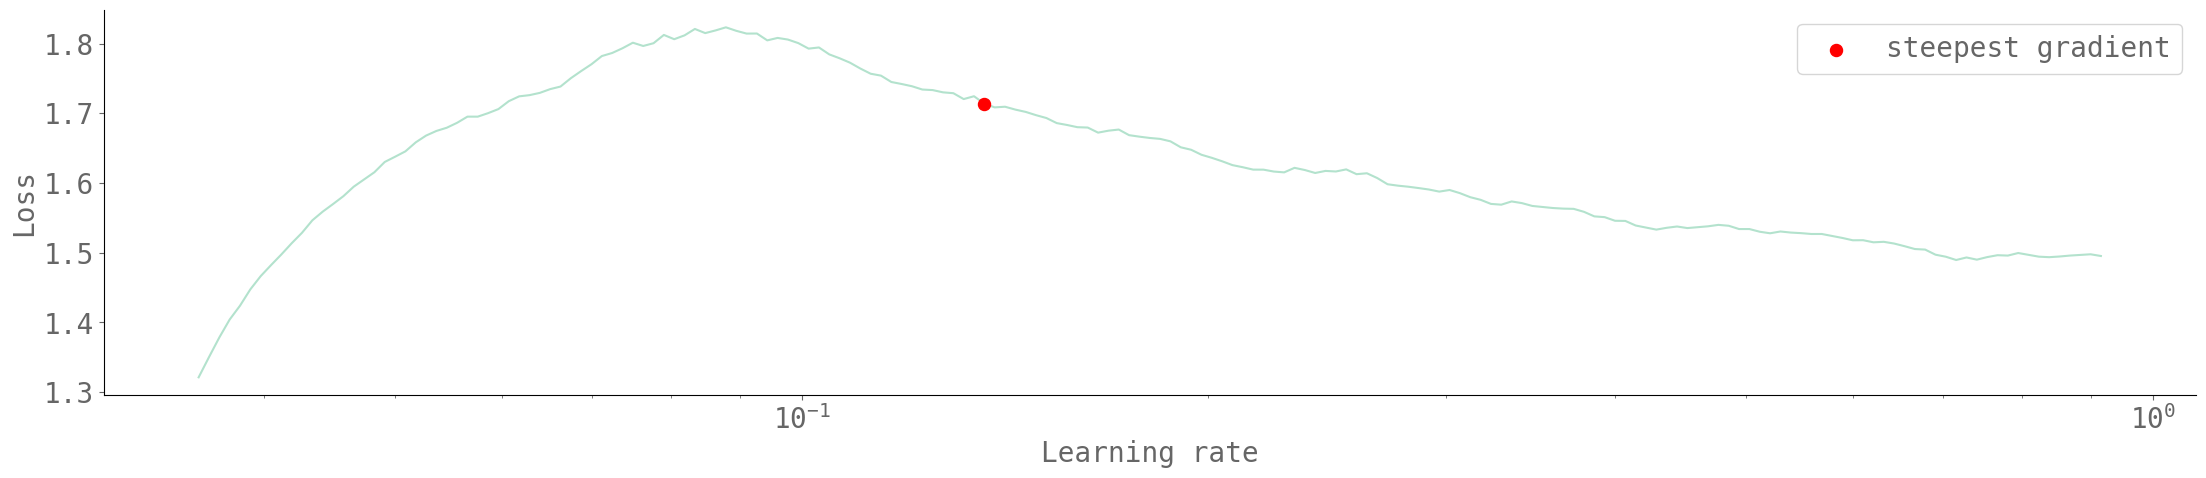


  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 11.2 M
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)
/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniforge/base/envs/torch-gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many wor

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [3]:

if __name__ == '__main__':
    trainer = Trainer(
        accelerator="mps", devices=1,
        max_epochs = epochs,
        num_sanity_val_steps=0,
        enable_progress_bar = True,
        default_root_dir="./ckp"
    )

    # Train the model
    resnet_18 = LitResnet()
    trainer.fit(resnet_18)

In [4]:
torch.save(resnet_18.state_dict(),
           "ckp/lightning_logs/saved_model.pth")

In [286]:
# ckp/lightning_logs/saved_model.pth

resnet_18 = LitResnet()
state_dict = torch.load("/Users/venkat/Documents/ERA/resnet18_cifar10/resnet.pth",
                        map_location=torch.device('cpu'))
resnet_18.load_state_dict(state_dict)
resnet_18_model = resnet_18.model#.to('mps:0')

In [254]:
torch.save(resnet_18_model.state_dict(), 
           "/Users/venkat/Documents/ERA/resnet18_cifar10/resnet_model.pth")

In [256]:
resnet_18_model = model.ResNet18()
state_dict = torch.load(
    "/Users/venkat/Documents/ERA/resnet18_cifar10/resnet_model.pth",
    map_location=torch.device('cpu'))
resnet_18_model.load_state_dict(state_dict)

<All keys matched successfully>

## Misclassified Images

In [85]:
test_dataset = CifarAlbumentationsDataset(
    "../data/", train=False, transform=TEST_TRANSFORM,)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

predictions = []
resnet_18_model.eval()
for data, target in test_dataloader:
    data = data.to('mps:0')
    output = resnet_18_model(data)
    pred = torch.argmax(output, dim=1).cpu().numpy()
    predictions.extend(pred)

In [89]:
misclassified_datapoints = [ind for ind, (pred, target) in enumerate(
    zip(predictions, test_dataset.targets)) if pred != target]
misclassified_datapoints = misclassified_datapoints[:100]

In [90]:
misclasif_images = test_dataset.data[misclassified_datapoints]
misclasif_targets = np.array(test_dataset.targets)[misclassified_datapoints]
misclasif_preds = np.array(predictions)[misclassified_datapoints]

In [96]:
misclassified = (misclasif_images, misclasif_targets, misclasif_preds)
torch.save(misclassified, 'misclassified_images.pt')
subset = torch.load('misclassified_images.pt')

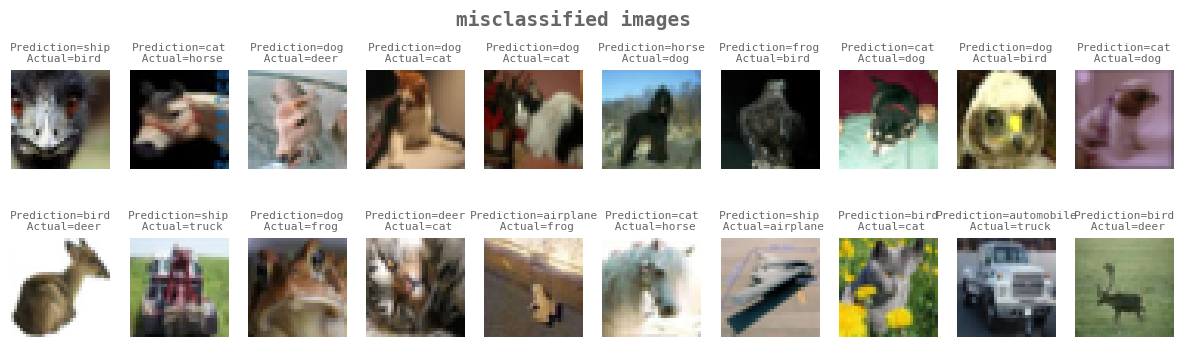

In [199]:

from data_loader import CIFAR_CLASS_LABELS

def show(images, actuals, preds, nrows=2, ncols=10, figsize=(15, 4)):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize )
    fig.suptitle('misclassified images', weight='bold', size=14)
    axes = axes.ravel()
    for i, (img, actual, pred, ax) in enumerate(zip(images, actuals, preds, axes)):
        ax.imshow(img)
        ax.set_title(
            f'Prediction={CIFAR_CLASS_LABELS[pred]}\n Actual={CIFAR_CLASS_LABELS[actual]}',
            fontsize=8)
        ax.set(xticks=[], yticks=[], xticklabels=[], yticklabels=[])
        ax.axis('off')
images = torch.tensor(subset[0])[:20]
show(images, *subset[1:])

In [287]:
import torch, torchvision
from torchvision import transforms
import numpy as np
import gradio as gr
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import gradio as gr
import model
import io


classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


In [283]:
resnet_18 = LitResnet()
state_dict = torch.load("ckp/lightning_logs/saved_model.pth", map_location=torch.device('cpu'))
resnet_18.load_state_dict(state_dict)
resnet_18_model = resnet_18.model

In [300]:
from tqdm import tqdm
from utils import GetCorrectPredCount

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    processed = 0
    criterion = nn.CrossEntropyLoss()
    pbar = tqdm(test_loader)
    with torch.no_grad():
      for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            correct += GetCorrectPredCount(output, target)
            processed += len(data)

            print('test_loss',  test_loss)

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    acc = 100. * correct / len(test_loader.dataset)
    print('test_acc',  acc)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        acc))

    test_acc.append(acc)
    return acc

In [304]:
from data_loader import CifarAlbumentationsDataset,\
    CIFAR_CLASS_LABELS, TRAIN_TRANSFORM, TEST_TRANSFORM
test_dataset = CifarAlbumentationsDataset('../data', train=False, transform=TEST_TRANSFORM)
test_loader = DataLoader(test_dataset, batch_size=1024,
        num_workers=1, pin_memory=True)

In [305]:
test(resnet_18_model.to('mps:0'), 'mps:0', test_loader)

10


NameError: name 'test_losses' is not defined